In [ ]:
# run to download glove embeddings, total 822MB
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d glove
!rm glove.6B.zip

In [3]:
%pip install --upgrade numpy
%pip install --upgrade scikit-learn

  Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (114 kB)
Using cached numpy-1.26.4-cp311-cp311-macosx_11_0_arm64.whl (14.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.3
    Uninstalling numpy-1.26.3:
      Successfully uninstalled numpy-1.26.3
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 20.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
Note: you may need to restart the kernel to use updated packages.


----
# Glove Embeddings

website available [here](https://nlp.stanford.edu/projects/glove/)

- using embeddings trained on Wikipedia 2014 and Gigaword 5 data
    - 6B tokens, 400K vocab, uncased, up to 300d vectors
    - embeddings come in 50, 100, 200, and 300 dimensions
- starting with 50d embeddings for speed
    - can run with larger embeddings to see difference in algorithm performance


In [123]:
# read the 50d embeddings and store in dictionary
import numpy as np
glove_50d = {}

with open('glove/glove.6B.50d.txt') as f:
    for line in f: # each line has a word followed by embedding vector (in a list)
        values = line.split()
        word = values[0] 
        vector = np.asarray(values[1:], dtype='float32')
        glove_50d[word] = vector

# reverse the mapping
glove_50d_inv = {tuple(v): k for k, v in glove_50d.items()}

In [3]:
# print the first word and its embedding
w = list(glove_50d.keys())[0]
print(w, glove_50d[w])

the [ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01]


In [21]:
# create a random subset of 10000 words
import random
random.seed(0) # for reproducability
glove_50d_subset = {k: glove_50d[k] for k in random.sample(list(glove_50d.keys()), 10000)}

w = list(glove_50d_subset.keys())[0]
print(w, glove_50d_subset[w])

50.33 [-1.0101   -0.36405   0.80063  -0.062386  0.52311   0.087354  0.35815
  0.32986  -0.83417   0.48727  -0.25585  -1.1345    1.1998   -0.065978
 -0.27127  -0.58135  -0.88292  -0.65163   0.62168  -0.34872  -0.011863
  0.51258   0.16594  -0.47244  -0.021005  0.60544   0.49036  -0.64506
 -0.28557   0.21463  -1.1864    0.55344  -0.96578   0.72193   0.22892
 -1.1234   -0.64796   0.24078   0.98892  -0.1422    0.13968  -0.28823
  0.44503   0.95702  -0.97695  -0.51403  -0.098698  0.34506   0.61214
 -0.64067 ]


In [93]:
# from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def bench_k_means(kmeans, name, data, labels):
    """
        - data passed in as ndarray ofr shape (n_samples, n_features)
        - labels passed in as ndarray of shape (n_samples,)
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data) # scale data then run kmeans
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # metrics that require true labels and estimated labels
    # https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]

    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # silhouette score for clusters
    silhouette_score = metrics.silhouette_score(data, estimator[-1].labels_, metric="euclidean", sample_size=300)
    results += [silhouette_score]
    
    # print results
    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))

In [95]:
from sklearn.cluster import KMeans

# arrange glove data into ndarray
glove_50d_subset_data = np.array(list(glove_50d_subset.values()))
glove_50d_subset_labels = np.array(list(glove_50d_subset.keys()))

print('K means clustering on glove 50d embeddings')
print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

kmeans = KMeans(init="k-means++", n_clusters=1000, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=glove_50d_subset_data, labels=glove_50d_subset_labels)

kmeans = KMeans(init="random", n_clusters=1000, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=glove_50d_subset_data, labels=glove_50d_subset_labels)

print(82 * '_')


__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	13.771s	253426	0.693	1.000	0.819	0.000	-0.000	-0.052
random   	0.611s	261765	0.696	1.000	0.821	0.000	-0.000	-0.033
__________________________________________________________________________________


Text(0, 0.5, '2nd eigenvector')

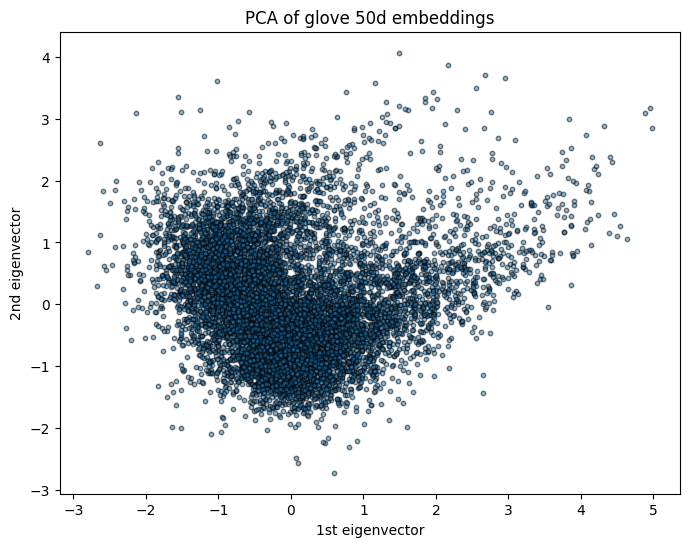

In [100]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# visualize the data in 2d
pca = PCA(n_components=2)
glove_50d_subset_data_pca = pca.fit_transform(glove_50d_subset_data)

plt.figure(figsize=(8, 6))
plt.scatter(glove_50d_subset_data_pca[:, 0], glove_50d_subset_data_pca[:, 1], s=10, alpha=0.5, edgecolors='black')
plt.title("PCA of glove 50d embeddings")
plt.xlabel("1st eigenvector")
plt.ylabel("2nd eigenvector")

In [103]:
# run kmeans on the PCA data
print('K means clustering on PCA of glove 50d embeddings')
print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

kmeans = KMeans(init="k-means++", n_clusters=1000, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=glove_50d_subset_data_pca, labels=glove_50d_subset_labels)

kmeans = KMeans(init="random", n_clusters=1000, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=glove_50d_subset_data_pca, labels=glove_50d_subset_labels)

print(82 * '_')

# VISUALIZATION NOT WORKING

K means clustering on PCA of glove 50d embeddings
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	1.719s	21	0.724	1.000	0.840	0.000	-0.000	0.126
random   	0.287s	41	0.742	1.000	0.852	0.000	-0.000	0.134
__________________________________________________________________________________


----
# Random Clusters for Alignment Checking
- For the alignment checking algorithm, want to find random clusters of words in the embedding space
    - We can find clusters of 100 words by randomly selecting a point in the embedding space and finding the closest 100 points
- Large size of the vocab leads to obscure words selected for clusters
    - Can also define "meaningful" clusters by choosing certain words to be in the cluster

In [136]:
# select 100 random words
random.seed(0)
random_words = random.sample(list(glove_50d.keys()), 100)
random_words_embeddings = np.array([glove_50d[w] for w in random_words])

glove_50d_data = np.array(list(glove_50d.values()))
glove_50d_labels = np.array(list(glove_50d.keys()))

# for each word, find the 99 nearest neighbours by euclidean distance
from sklearn.metrics import pairwise_distances
distances = pairwise_distances(random_words_embeddings, glove_50d_data, metric='euclidean')
nearest_neighbours = np.argsort(distances, axis=1)[:, 1:100]

# print the first 5 random words and their 5 nearest neighbours
for i, w in enumerate(random_words):
    print(w, [glove_50d_inv[tuple(glove_50d_data[j])] for j in nearest_neighbours[i]][:5])
    if i == 5 : break


50.33 ['46.21', '60.92', '41.51', '50.43', '49.87']
zapolice ['krzysztoporska', 'szadek', 'lelis', 'rymań', 'rojewo']
amcol ['promet', 'uraco', '-8.00', 'uniwide', 'plunders']
supplementary ['supplemental', 'supplemented', 'allocation', 'guideline', 'retention']
chutneys ['salsas', 'risottos', 'mangos', 'condiments', 'gratins']
53.19 ['39.23', '34.64', '47.02', '35.73', '42.42']
